## **1.Subtask 1 - Polarization detection**


### **1.1 Imports**

In [1]:
#!unzip dev_phase.zip

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import random
from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset

import os
import zipfile
from typing import Dict

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [38]:
!pip install iterative-stratification

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score,confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime

import joblib
import seaborn as sns


In [5]:
!pip install -q nltk
!pip install -q transformers sentencepiece
from transformers import MarianMTModel, MarianTokenizer
import math

In [6]:
from transformers import set_seed
def set_global_seed(seed: int = 42):
    """
    Set seed for reproducibility across Python, NumPy, PyTorch, and Hugging Face Transformers.

    Args:
        seed (int): Seed value to use.
    """


    # Python built-in random
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    # CUDNN settings for deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Hugging Face Transformers
    set_seed(seed)

    print(f"[INFO] Global seed set to {seed}")


In [7]:
set_global_seed(42)

[INFO] Global seed set to 42


#### **1.1.1 Helper Functions**

In [31]:

def plot_top_tfidf_words(tfidf_vectorizer, X, top_k=20, title="Top TF-IDF Words",naming='tf idf'):
    """
    Plot top-k words by mean TF-IDF score.
    """
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    mean_tfidf = X.mean(axis=0).A1

    top_idx = mean_tfidf.argsort()[-top_k:][::-1]

    plt.figure(figsize=(10,6))
    plt.barh(feature_names[top_idx][::-1], mean_tfidf[top_idx][::-1])
    plt.xlabel("Mean TF-IDF Score")
    plt.title(title)
    plt.tight_layout()

    plt.savefig(f'drive/MyDrive/NLP/top_words_aug_{naming}.pdf',format='pdf',dpi=300)
    plt.show()

def plot_confusion_matrix_binary(y_true, y_pred, title,naming):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Not Polarized", "Polarized"]
    )
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.savefig(f'drive/MyDrive/NLP/confusion_mat_aug_{naming}.pdf',format='pdf',dpi=300)
    plt.show()

def plot_label_confusion_matrix(y_true, y_pred, label_names, title,naming):
    """
    Plot a label-label confusion matrix for multi-label classification.

    y_true: DataFrame (n_samples, n_labels)
    y_pred: ndarray (n_samples, n_labels)
    """
    n_labels = len(label_names)
    matrix = np.zeros((n_labels, n_labels), dtype=int)

    for i in range(n_labels):
        for j in range(n_labels):
            # Count samples where label i is true and label j is predicted
            matrix[i, j] = np.sum(
                (y_true.iloc[:, i] == 1) & (y_pred[:, j] == 1)
            )

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        matrix,
        xticklabels=label_names,
        yticklabels=label_names,
        annot=True,
        fmt="d",
        cmap="Blues"
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f'drive/MyDrive/NLP/multi_confusion_mat_aug_{naming}.pdf',format='pdf',dpi=300)
    plt.show()


### 1.2 **Data Import**

In [9]:
# Load the training and validation data for subtask 1
train_eng_all = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask1/train/eng.csv')
train_hau_all = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask1/train/hau.csv')



#### **Data Augmentation Functions**

##### **English**

In [10]:
# English -> French
en_fr_model_name = 'Helsinki-NLP/opus-mt-en-fr'
en_fr_tokenizer = MarianTokenizer.from_pretrained(en_fr_model_name)
en_fr_model = MarianMTModel.from_pretrained(en_fr_model_name)

# French -> English
fr_en_model_name = 'Helsinki-NLP/opus-mt-fr-en'
fr_en_tokenizer = MarianTokenizer.from_pretrained(fr_en_model_name)
fr_en_model = MarianMTModel.from_pretrained(fr_en_model_name)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
en_fr_model.to(device)
fr_en_model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(59514, 512, padding_idx=59513)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(59514, 512, padding_idx=59513)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [11]:

def translate(texts, model, tokenizer, device='cpu', max_length=128):
    batch = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
    translated = model.generate(**batch, max_length=max_length)
    translated_texts = [tokenizer.decode(t, skip_special_tokens=True) for t in translated]
    return translated_texts


def back_translate_en(texts, device='cpu'):
    # English -> French -> English
    fr_texts = translate(texts, en_fr_model, en_fr_tokenizer, device=device)
    back_translated_texts = translate(fr_texts, fr_en_model, fr_en_tokenizer, device=device)
    return back_translated_texts

In [12]:
def augment_minority_backtranslation_batch(df, text_col='text', label_col='polarization',
                                           translate_fn=None, device='cpu', n_augments=3,
                                           batch_size=16, shuffle=True, lang='English'):
    """
    Augment minority class using batch back-translation for multiple samples per sentence.
    """
    # Detect minority class
    minority_label = df[label_col].value_counts().idxmin()
    minority_class = df[df[label_col] == minority_label].copy()

    augmented_rows = []
    texts = minority_class[text_col].tolist()
    total_batches = math.ceil(len(texts) / batch_size)

    desc_text = f"Back-translating minority class (batch): {lang}"
    for batch_idx in tqdm(range(total_batches), desc=desc_text):
        batch_texts = texts[batch_idx*batch_size:(batch_idx+1)*batch_size]
        for _ in range(n_augments):
            augmented_texts = translate_fn(batch_texts, device=device)
            for i, aug_text in enumerate(augmented_texts):
                new_row = minority_class.iloc[batch_idx*batch_size + i].copy()
                new_row[text_col] = aug_text
                augmented_rows.append(new_row)

    augmented_df = pd.DataFrame(augmented_rows)

    # Append to original dataframe
    df_augmented = pd.concat([df, augmented_df], ignore_index=True)

    if shuffle:
        df_augmented = df_augmented.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_augmented

##### **Hausa**

In [13]:

# Hausa -> English
ha_en_model_name = 'Helsinki-NLP/opus-mt-ha-en'
ha_en_tokenizer = MarianTokenizer.from_pretrained(ha_en_model_name)
ha_en_model = MarianMTModel.from_pretrained(ha_en_model_name)

# English -> Hausa
en_ha_model_name = 'Helsinki-NLP/opus-mt-en-ha'
en_ha_tokenizer = MarianTokenizer.from_pretrained(en_ha_model_name)
en_ha_model = MarianMTModel.from_pretrained(en_ha_model_name)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
ha_en_model.to(device)
en_ha_model.to(device)



tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/783k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/783k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(58089, 512, padding_idx=58088)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(58089, 512, padding_idx=58088)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [14]:
def back_translate_hausa(texts, device='cpu'):
    # Hausa -> English
    english_texts = translate(texts, ha_en_model, ha_en_tokenizer, device=device)
    # English -> Hausa
    back_translated_texts = translate(english_texts, en_ha_model, en_ha_tokenizer, device=device)
    return back_translated_texts


In [15]:

def back_translate_batch(texts, translate_fn, device='cpu', batch_size=16):
    """
    Back-translate a list of texts in batches.

    Args:
        texts (list): List of input sentences.
        translate_fn (callable): Translation function that accepts a list of texts.
        device (str): 'cpu' or 'cuda'.
        batch_size (int): Number of sentences to process per batch.

    Returns:
        list: Back-translated texts.
    """
    augmented_texts = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Back-translating batches"):
        batch = texts[i:i+batch_size]
        back_translated_batch = translate_fn(batch, device=device)
        augmented_texts.extend(back_translated_batch)
    return augmented_texts


#### **Data Train Split and Augumentation**

In [18]:
train_eng_org, val_eng = train_test_split(
    train_eng_all,
    test_size=0.1,
    shuffle=True,
    stratify=train_eng_all['polarization'],
    random_state=40
)

train_hau_org, val_hau = train_test_split(
    train_hau_all,
    test_size=0.1,
    shuffle=True,
    stratify=train_hau_all['polarization'],
    random_state=40
)

# English back-translation augmentation
train_eng = augment_minority_backtranslation_batch(
    train_eng_org,
    text_col='text',
    label_col='polarization',
    translate_fn=back_translate_en,
    device=device,
    n_augments=3,   # number of augmented versions per sentence
    batch_size=16,
    lang='English'
)

# Hausa back-translation augmentation
train_hau = augment_minority_backtranslation_batch(
    train_hau_org,
    text_col='text',
    label_col='polarization',
    translate_fn=back_translate_hausa,
    device=device,
    n_augments=3,
    batch_size=16,
    lang='Hausa'
)

train_t1 = pd.concat([train_eng , train_hau], ignore_index=True)
val_t1 = pd.concat([val_eng, val_hau], ignore_index=True)



dev_set_eng=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask1/dev/eng.csv')
dev_set_hau=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask1/dev/hau.csv')


train_t1.head()

Back-translating minority class (batch): Hausa: 100%|██████████| 23/23 [02:28<00:00,  6.44s/it]


,id,text,polarization
0,eng_f82bf24bb69513c098efddd005850030,Dont forget we were sick of open borders and a...,0
1,eng_312041e208a9399c5de0ea147e97335e,"Maine shooting, IsraelHamas war, US airstrikes...",0
2,eng_a10afd69b74af3c3b908638a788da631,No surprise breitbart is incapable of distingu...,1
3,eng_4cd725129873668d0da96ee873a0e290,Many speeches on the right to vote today from ...,1
4,eng_f3805f10a52cf2001a4a36f174041f8d,Islamic University of Gaza in Palestine,1


#### **Data Exploration**

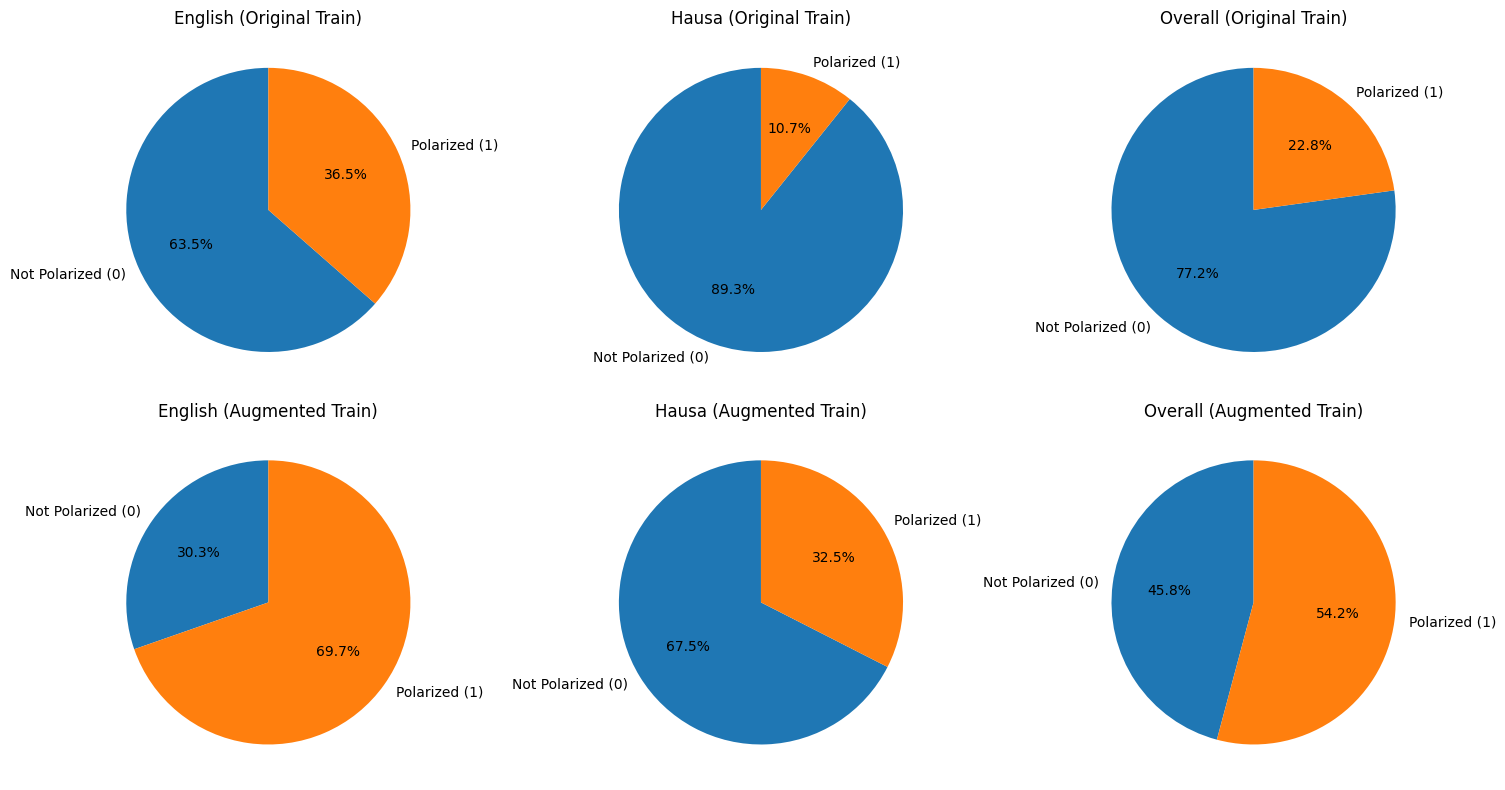

In [19]:
import matplotlib.pyplot as plt

# Compute distributions
dist_eng_orig = train_eng_org['polarization'].value_counts().sort_index()
dist_hau_orig = train_hau_org['polarization'].value_counts().sort_index()

dist_eng_aug = train_eng['polarization'].value_counts().sort_index()
dist_hau_aug = train_hau['polarization'].value_counts().sort_index()

labels = ['Not Polarized (0)', 'Polarized (1)']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# ---------------------
# Original distributions
# ---------------------
axes[0, 0].pie(dist_eng_orig, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title("English (Original Train)")

axes[0, 1].pie(dist_hau_orig, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title("Hausa (Original Train)")

dist_overall_orig = pd.concat([train_eng_org, train_hau_org], ignore_index=True)['polarization'].value_counts().sort_index()
axes[0, 2].pie(dist_overall_orig, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 2].set_title("Overall (Original Train)")

# ---------------------
# Augmented distributions
# ---------------------
axes[1, 0].pie(dist_eng_aug, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title("English (Augmented Train)")

axes[1, 1].pie(dist_hau_aug, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title("Hausa (Augmented Train)")

dist_overall_aug = pd.concat([train_eng, train_hau], ignore_index=True)['polarization'].value_counts().sort_index()
axes[1, 2].pie(dist_overall_aug, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title("Overall (Augmented Train)")

plt.tight_layout()
naming='TF_IDF Aug T1 data'
plt.savefig(f'drive/MyDrive/NLP/{naming}.pdf',format='pdf',dpi=300)
plt.show()


### **1.3 TF-IDF Vectorizer & DataSet**


In [20]:
tfidf=TfidfVectorizer(
    ngram_range=(1,2),
    max_features=10000,
    sublinear_tf=True
)
# TF-IDF
X_train_t1 = tfidf.fit_transform(train_t1['text'])
X_val_t1 = tfidf.transform(val_t1['text'])

# Labels
y_train_t1 = train_t1['polarization']
y_val_t1 = val_t1['polarization']


### **1.4 Model Training**

#### **1.4.1 Training Model**

In [45]:
def train_evaluate_logreg(X_train, y_train, X_val, y_val, multi_label=False):
    if multi_label:
        # Use one-vs-rest scheme for multi-label classification
        from sklearn.multiclass import OneVsRestClassifier
        clf = OneVsRestClassifier(LogisticRegression(max_iter=1000,random_state=42))
    else:
        clf = LogisticRegression(max_iter=1000,random_state=42)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    # Metrics
    if multi_label:
        f1_macro = f1_score(y_val, y_pred, average='macro')
        f1_micro = f1_score(y_val, y_pred, average='micro')
        return clf, {'f1_macro': f1_macro, 'f1_micro': f1_micro}
    else:
        accuracy = accuracy_score(y_val, y_pred)
        f1_macro = f1_score(y_val, y_pred, average='macro')
        f1_micro = f1_score(y_val, y_pred, average='micro')
        return clf, {'accuracy': accuracy, 'f1_macro': f1_macro, 'f1_micro': f1_micro}


In [22]:
# Train Logistic Regression
clf_t1, metrics_t1 = train_evaluate_logreg(X_train_t1, y_train_t1, X_val_t1, y_val_t1)
print("Subtask 1 metrics:", metrics_t1)

Subtask 1 metrics: {'accuracy': 0.7895500725689405, 'f1_macro': 0.730741139023871, 'f1_micro': 0.7895500725689405}


#### **1.4.2 Testing Dev Set**

In [24]:
X_dev_eng_t1 = tfidf.transform(dev_set_eng['text'])
X_dev_hau_t1 = tfidf.transform(dev_set_hau['text'])

# Predict
y_dev_eng_t1 = clf_t1.predict(X_dev_eng_t1)
y_dev_hau_t1 = clf_t1.predict(X_dev_hau_t1)

pred_data_t1 = {
    "eng": {'ids': dev_set_eng['id'].tolist(), 'results': y_dev_eng_t1},
    "hau": {'ids': dev_set_hau['id'].tolist(), 'results': y_dev_hau_t1}
}


#### **1.4.3 Making Submission Package**

In [25]:
# --- Helper: Save a single prediction CSV ---
def save_prediction_csv(df: pd.DataFrame, lang_code: str, folder: str):
    """Save a DataFrame as a csv."""
    file_path = os.path.join(folder, f"pred_{lang_code}.csv")
    df.to_csv(file_path, index=False)
    return file_path

# --- Helper: Zip a folder ---
def zip_folder(folder_path: str, zip_path: str):
    """Create a zip file of the folder."""
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, os.path.dirname(folder_path))
                zipf.write(file_path, arcname)

# --- Main function: Create submission zip ---
def create_submission_zip(task,predictions: Dict[str, pd.DataFrame], output_dir=".",):
    """
    function to create submission zip for Subtask.
    """
    zip_name=f"{task}.zip"
    # Folder for submission files
    submission_folder = os.path.join(output_dir, task)
    os.makedirs(submission_folder, exist_ok=True)

    # Save each prediction CSV
    for lang_code, df in predictions.items():
        save_prediction_csv(df, lang_code, submission_folder)

    # Create zip
    zip_path = os.path.join(output_dir, zip_name)
    zip_folder(submission_folder, zip_path)
    print(f"Submission zip created at: {zip_path}")


In [26]:
submission_dict = {}

for lang in pred_data_t1:
    df = pd.DataFrame({
        "id": pred_data_t1[lang]['ids'],
        "polarization": pred_data_t1[lang]['results']
    })
    submission_dict[lang] = df

create_submission_zip('subtask_1',submission_dict)

Submission zip created at: ./subtask_1.zip


#### **1.4.4 Saving the Model**

In [27]:
def save_model(model, path: str):
    """Save a sklearn model to disk."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    joblib.dump(model, path)
    print(f"Model saved at: {path}")

In [28]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
naming='TF_IDF Aug'
save_path = f"saved_model_t1_{naming}_f1_{metrics_t1['f1_macro']:.4f}_{timestamp}"
save_model(clf_t1, 'drive/MyDrive/NLP/models'+'//'+save_path)

Model saved at: drive/MyDrive/NLP/models//saved_model_t1_TF_IDF Aug_f1_0.7307_20251215_175029


### **1.5 Plot of Important Words**

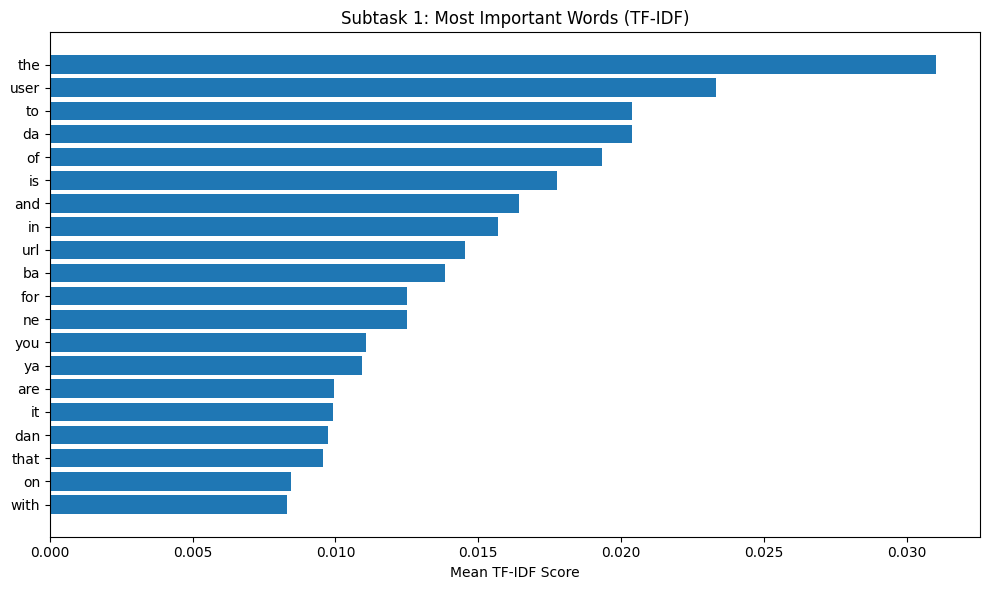

In [32]:
plot_top_tfidf_words(
    tfidf,
    X_train_t1,
    top_k=20,
    title="Subtask 1: Most Important Words (TF-IDF)",
    naming='TF IDF_T1_words'
)

### **1.6 Confusion Matrix**

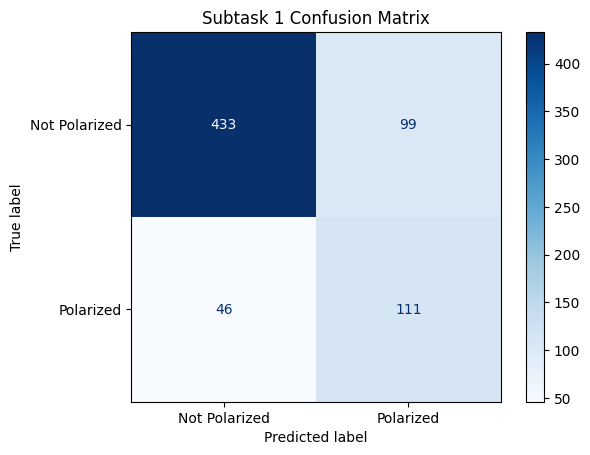

In [33]:
y_val_pred_t1 = clf_t1.predict(X_val_t1)

plot_confusion_matrix_binary(
    y_val_t1,
    y_val_pred_t1,
    title="Subtask 1 Confusion Matrix",
    naming='TF IDF_T1'
)

# **2.Subtask 2: Polarization Type Classification**

### **2.1 Data Import**

#### **Data Augmentation Functions**

In [34]:
def augment_multilabel_backtranslation(
    df,
    text_col,
    label_cols,
    translate_fn,
    device='cpu',
    rare_label_threshold=0.15,
    n_augments=2,
    batch_size=16,
    lang='English'
):
    """
    Back-translation augmentation for multi-label datasets.
    Augments only samples containing rare labels.
    """

    #Computing label frequencies
    label_freq = df[label_cols].mean()
    rare_labels = label_freq[label_freq < rare_label_threshold].index.tolist()

    print(f"[{lang}] Rare labels:", rare_labels)

    #Selecting rows containing at least one rare label
    mask = df[rare_labels].sum(axis=1) > 0
    target_df = df[mask].copy()

    print(f"[{lang}] Samples selected for augmentation: {len(target_df)}")

    if len(target_df) == 0:
        return df

    augmented_rows = []
    texts = target_df[text_col].tolist()
    total_batches = math.ceil(len(texts) / batch_size)

    for batch_idx in tqdm(range(total_batches), desc=f"Back-translating ({lang})"):
        batch_texts = texts[batch_idx*batch_size:(batch_idx+1)*batch_size]

        for _ in range(n_augments):
            augmented_texts = translate_fn(batch_texts, device=device)

            for i, aug_text in enumerate(augmented_texts):
                row = target_df.iloc[batch_idx*batch_size + i].copy()
                row[text_col] = aug_text
                augmented_rows.append(row)

    augmented_df = pd.DataFrame(augmented_rows)

    #Merge & shuffle
    df_augmented = pd.concat([df, augmented_df], ignore_index=True)
    df_augmented = df_augmented.sample(frac=1, random_state=42).reset_index(drop=True)

    return df_augmented

#### **Data Train Split and Augumentation**

In [39]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

def multilabel_split(df, labels, test_size=0.1, seed=40):
    splitter = MultilabelStratifiedShuffleSplit(
        n_splits=1,
        test_size=test_size,
        random_state=seed
    )
    X = df.index.values
    y = df[labels].values

    for train_idx, val_idx in splitter.split(X, y):
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]

    return train_df, val_df

In [40]:

train_eng_all_t2 = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask2/train/eng.csv')
train_hau_all_t2 = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask2/train/hau.csv')

labels = ['gender/sexual','political','religious','racial/ethnic','other']

train_eng_org_t2, val_eng = multilabel_split(train_eng_all_t2, labels)
train_hau_org_t2, val_hau = multilabel_split(train_hau_all_t2, labels)

train_eng_t2 = augment_multilabel_backtranslation(
    train_eng_org_t2,
    text_col='text',
    label_cols=labels,
    translate_fn=back_translate_en,
    device=device,
    rare_label_threshold=0.20,
    n_augments=2,
    batch_size=16,
    lang='English'
)

train_hau_t2 = augment_multilabel_backtranslation(
    train_hau_org_t2,
    text_col='text',
    label_cols=labels,
    translate_fn=back_translate_hausa,
    device=device,
    rare_label_threshold=0.20,
    n_augments=3,
    batch_size=16,
    lang='Hausa'
)



train_t2 = pd.concat([train_eng_t2, train_hau_t2], ignore_index=True)
val_t2 = pd.concat([val_eng, val_hau], ignore_index=True)



dev_set_eng_t2=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask2/dev/eng.csv')
dev_set_hau_t2=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask2/dev/hau.csv')

train_t2.head()

[English] Rare labels: ['gender/sexual', 'religious', 'racial/ethnic', 'other']
[English] Samples selected for augmentation: 404


Back-translating (English): 100%|██████████| 26/26 [02:07<00:00,  4.91s/it]


[Hausa] Rare labels: ['gender/sexual', 'political', 'religious', 'racial/ethnic', 'other']
[Hausa] Samples selected for augmentation: 354


Back-translating (Hausa): 100%|██████████| 23/23 [02:18<00:00,  6.02s/it]


,id,text,political,racial/ethnic,religious,gender/sexual,other
0,eng_abf4d40839816e0abe3f44e7ee75fe6e,"Its essentially ""inspired flight"" but with a s...",1,1,0,0,0
1,eng_c3fd7dbb83cf061b5cc4c34b5f1c3ad6,Ukraine remains resilient in the face of Russi...,0,0,0,0,0
2,eng_90a6d5ae4b31bed1a5b8b4b7b997438f,Where did all the proPalestine antigenocide pe...,1,0,0,0,0
3,eng_f0d5e316b37b7c87bb5e1f55582b9da8,PBPD Officer Retires After 33-Year Career,0,0,0,0,0
4,eng_dc569943086027fdbf85d874f02f6f5a,Police ID Man Killed While Riding Bike,0,0,0,0,0


#### **Data Exploration**

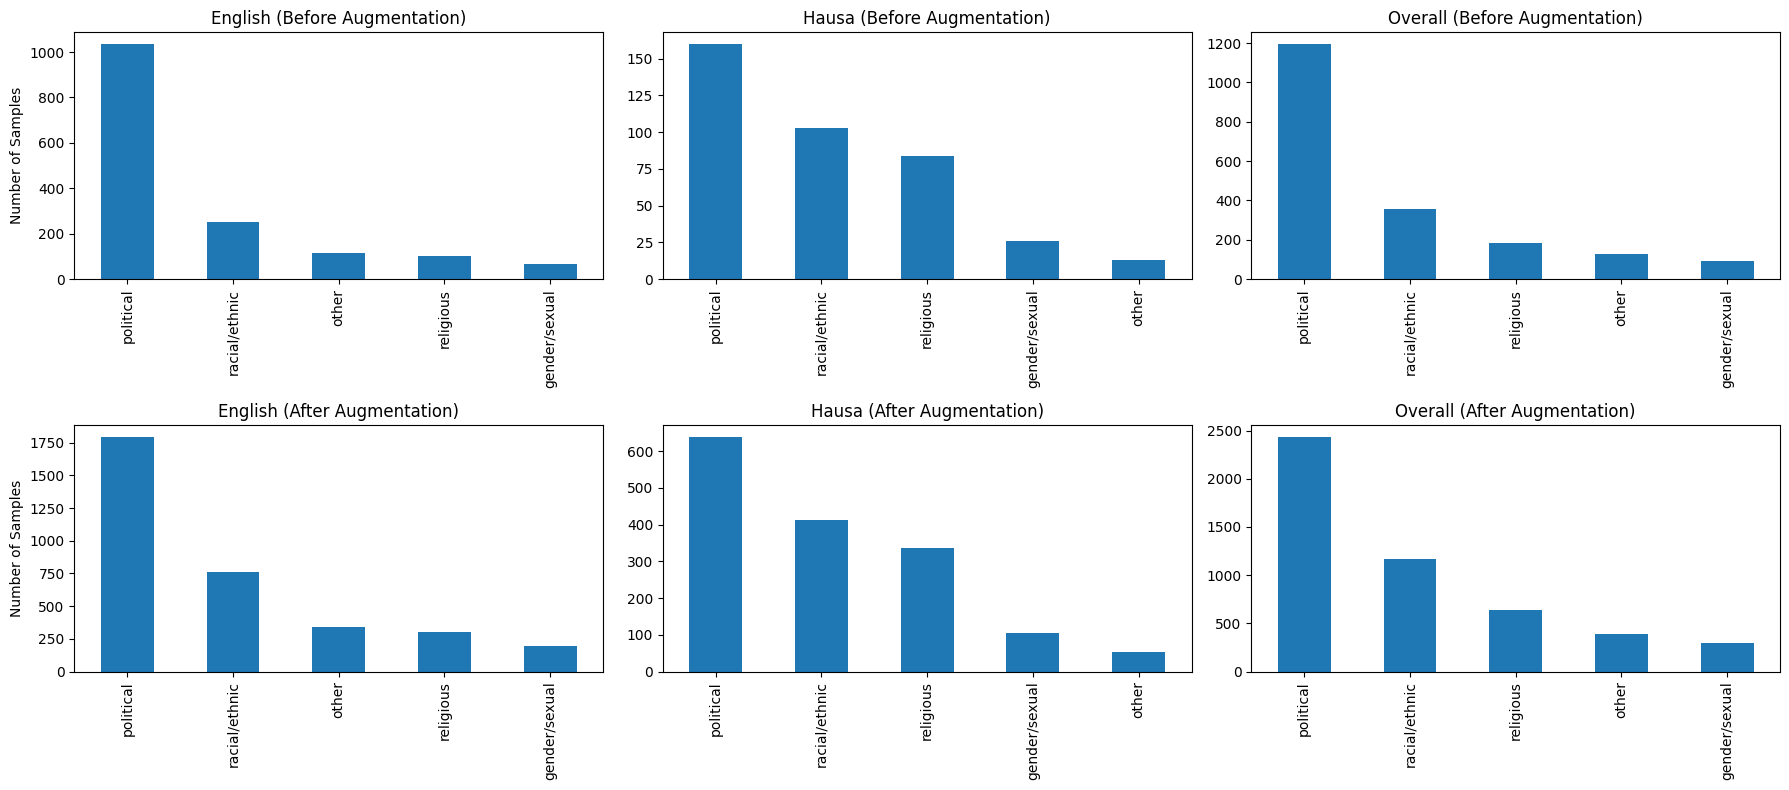

In [41]:
# Label columns
labels = ['gender/sexual','political','religious','racial/ethnic','other']

# BEFORE augmentation
dist_eng_before = train_eng_org_t2[labels].sum().sort_values(ascending=False)
dist_hau_before = train_hau_org_t2[labels].sum().sort_values(ascending=False)

train_t2_before = pd.concat([train_eng_org_t2, train_hau_org_t2], ignore_index=True)
dist_overall_before = train_t2_before[labels].sum().sort_values(ascending=False)

# AFTER augmentation
dist_eng_after = train_eng_t2[labels].sum().sort_values(ascending=False)
dist_hau_after = train_hau_t2[labels].sum().sort_values(ascending=False)
dist_overall_after = train_t2[labels].sum().sort_values(ascending=False)


fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Row 1 — BEFORE
dist_eng_before.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title("English (Before Augmentation)")
axes[0, 0].set_ylabel("Number of Samples")

dist_hau_before.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title("Hausa (Before Augmentation)")

dist_overall_before.plot(kind='bar', ax=axes[0, 2])
axes[0, 2].set_title("Overall (Before Augmentation)")

# Row 2 — AFTER
dist_eng_after.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title("English (After Augmentation)")
axes[1, 0].set_ylabel("Number of Samples")

dist_hau_after.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title("Hausa (After Augmentation)")

dist_overall_after.plot(kind='bar', ax=axes[1, 2])
axes[1, 2].set_title("Overall (After Augmentation)")

plt.tight_layout()
naming='TF IDF Aug T2 data bars'
plt.savefig(f'drive/MyDrive/NLP/{naming}.pdf',format='pdf',dpi=300)
plt.show()



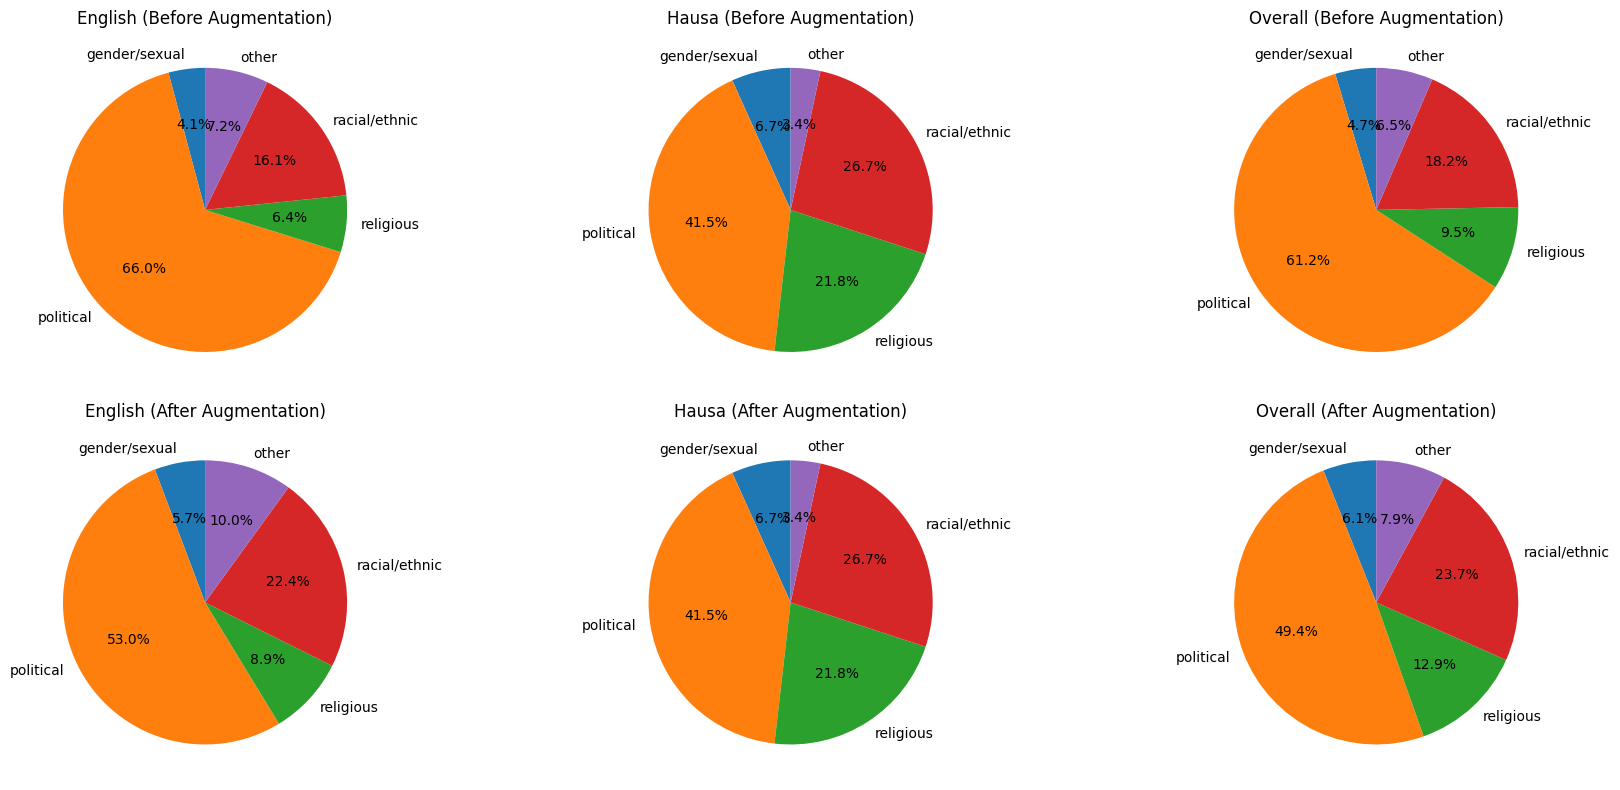

Desired Label Distribution: 20.00% per class


In [42]:
# Label columns
labels = ['gender/sexual','political','religious','racial/ethnic','other']

# BEFORE augmentation
dist_eng_before = train_eng_org_t2[labels].sum()
dist_hau_before = train_hau_org_t2[labels].sum()

train_t2_before = pd.concat([train_eng_org_t2, train_hau_org_t2], ignore_index=True)
dist_overall_before = train_t2_before[labels].sum()

#  AFTER augmentation
dist_eng_after = train_eng_t2[labels].sum()
dist_hau_after = train_hau_t2[labels].sum()
dist_overall_after = train_t2[labels].sum()

fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Row 1 — BEFORE
axes[0, 0].pie(dist_eng_before, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title("English (Before Augmentation)")

axes[0, 1].pie(dist_hau_before, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title("Hausa (Before Augmentation)")

axes[0, 2].pie(dist_overall_before, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 2].set_title("Overall (Before Augmentation)")

# Row 2 — AFTER
axes[1, 0].pie(dist_eng_after, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title("English (After Augmentation)")

axes[1, 1].pie(dist_hau_after, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title("Hausa (After Augmentation)")

axes[1, 2].pie(dist_overall_after, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title("Overall (After Augmentation)")

plt.tight_layout()
naming='TF IDF Aug T2 data pie'
plt.savefig(f'drive/MyDrive/NLP/{naming}.pdf',format='pdf',dpi=300)
plt.show()

print(f"Desired Label Distribution: {100/len(labels):.02f}% per class")


### **2.2 TF-IDF Vectorizer & DataSet**

In [43]:
tfidf=TfidfVectorizer(
    ngram_range=(1,2),
    max_features=10000,
    sublinear_tf=True
)

# TF-IDF
X_train_t2 = tfidf.fit_transform(train_t2['text'])
X_val_t2 = tfidf.transform(val_t2['text'])

# Labels
labels_t2 = ['gender/sexual','political','religious','racial/ethnic','other']
y_train_t2 = train_t2[labels_t2]
y_val_t2 = val_t2[labels_t2]

### **2.3 Model Training**

#### **2.4.1 Model Training**

In [46]:
clf_t2, metrics_t2 = train_evaluate_logreg(X_train_t2, y_train_t2, X_val_t2, y_val_t2, multi_label=True)
print("Subtask 2 metrics:", metrics_t2)


Subtask 2 metrics: {'f1_macro': 0.18310291858678956, 'f1_micro': 0.42443729903536975}


#### **2.4.2 Testing Dev Set**

In [47]:
X_dev_eng_t2 = tfidf.transform(dev_set_eng_t2['text'])
X_dev_hau_t2 = tfidf.transform(dev_set_hau_t2['text'])

y_dev_eng_t2 = clf_t2.predict(X_dev_eng_t2)
y_dev_hau_t2 = clf_t2.predict(X_dev_hau_t2)

labels_t2 = ['gender/sexual','political','religious','racial/ethnic','other']

pred_data_t2 = {
    "eng": {'ids': dev_set_eng_t2['id'].tolist(), 'results': y_dev_eng_t2},
    "hau": {'ids': dev_set_hau_t2['id'].tolist(), 'results': y_dev_hau_t2}
}

#### **2.3.3 Making Submission Package**

In [48]:
submission_dict = {}
for lang in pred_data_t2:
    df = pd.DataFrame({"id": pred_data_t2[lang]['ids'], **{lbl: pred_data_t2[lang]['results'][:,i] for i,lbl in enumerate(labels_t2)}})
    submission_dict[lang] = df


create_submission_zip('subtask_2',submission_dict)

Submission zip created at: ./subtask_2.zip


#### **2.3.4 Saving the Model**

In [49]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
naming='TF_IDF Aug'
save_path = f"saved_model_t2_{naming}_f1_{metrics_t2['f1_macro']:.4f}_{timestamp}"
save_model(clf_t1, 'drive/MyDrive/NLP/models'+'//'+save_path)

Model saved at: drive/MyDrive/NLP/models//saved_model_t2_TF_IDF Aug_f1_0.1831_20251215_181101


### **2.5 Plot of Important Words**

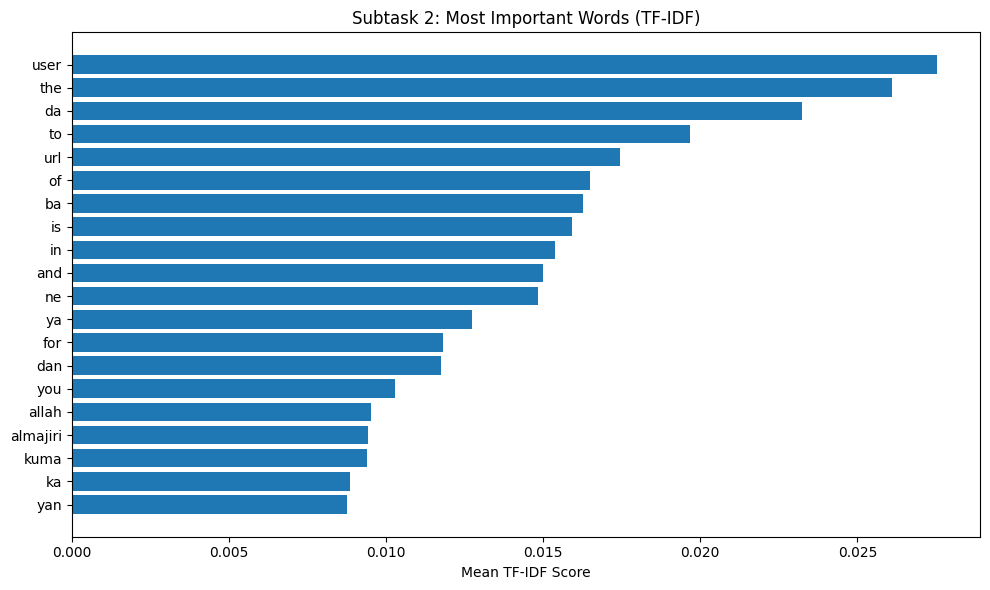

In [50]:
plot_top_tfidf_words(
    tfidf,
    X_train_t2,
    top_k=20,
    title="Subtask 2: Most Important Words (TF-IDF)",
    naming='TF IDF_T1_words'
)

### **2.6 Confusion Matrix**

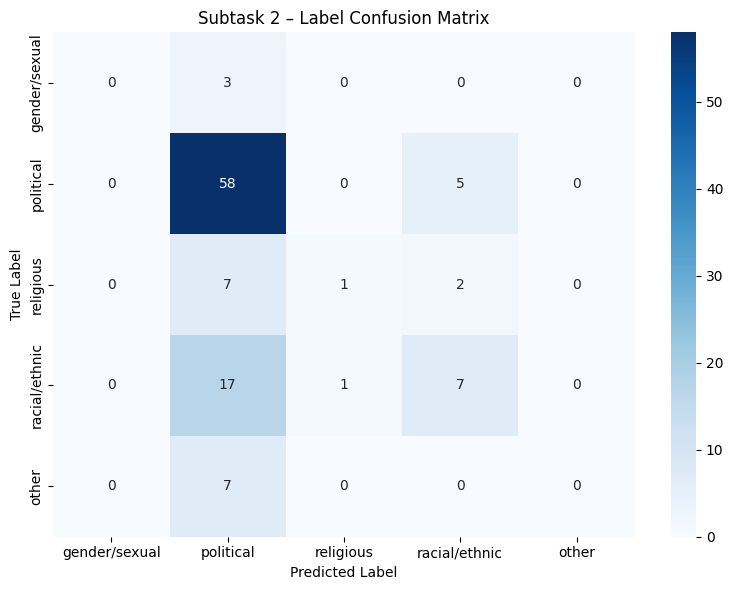

In [51]:
y_val_pred_t2 = clf_t2.predict(X_val_t2)

plot_label_confusion_matrix(
    y_val_t2,
    y_val_pred_t2,
    labels_t2,
    title="Subtask 2 – Label Confusion Matrix",
    naming='TF IDF_T2'
)

# 3.Subtask 3: Manifestation Identification
Multi-label classification to classify how polarization is expressed, with multiple possible labels including Vilification, Extreme Language, Stereotype, Invalidation, Lack of Empathy, and Dehumanization.



### **3.1 Data Import**

#### **Data Train Split and Augumentation**

In [52]:
# Labels
labels = ['stereotype', 'vilification', 'dehumanization',
          'extreme_language', 'lack_of_empathy', 'invalidation']
train_eng_all_t3 = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask3/train/eng.csv')
train_hau_all_t3 = pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask3/train/hau.csv')

train_eng_org_t3, val_eng = multilabel_split(train_eng_all_t3, labels)
train_hau_org_t3, val_hau = multilabel_split(train_hau_all_t3, labels)

train_eng_t3 = augment_multilabel_backtranslation(
    train_eng_org_t3,
    text_col='text',
    label_cols=labels,
    translate_fn=back_translate_en,
    device=device,
    rare_label_threshold=0.16,
    n_augments=2,
    batch_size=16,
    lang='English'
)

train_hau_t3 = augment_multilabel_backtranslation(
    train_hau_org_t3,
    text_col='text',
    label_cols=labels,
    translate_fn=back_translate_hausa,
    device=device,
    rare_label_threshold=0.16,
    n_augments=3,
    batch_size=16,
    lang='Hausa'
)



train_t3 = pd.concat([train_eng_t3, train_hau_t3], ignore_index=True)
val_t3 = pd.concat([val_eng, val_hau], ignore_index=True)



dev_set_eng_t3=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask3/dev/eng.csv')
dev_set_hau_t3=pd.read_csv('drive/MyDrive/NLP/dev_phase/subtask3/dev/hau.csv')


train_t3.head()

[English] Rare labels: ['stereotype', 'dehumanization', 'lack_of_empathy']
[English] Samples selected for augmentation: 721


Back-translating (English): 100%|██████████| 46/46 [01:50<00:00,  2.40s/it]


[Hausa] Rare labels: ['stereotype', 'vilification', 'dehumanization', 'extreme_language', 'lack_of_empathy', 'invalidation']
[Hausa] Samples selected for augmentation: 354


Back-translating (Hausa): 100%|██████████| 23/23 [02:22<00:00,  6.20s/it]


,id,text,stereotype,vilification,dehumanization,extreme_language,lack_of_empathy,invalidation
0,eng_77a20fece94dfac48ed3543d047a2171,Tim Scott blames Joe Biden for ongoing IsraelH...,0,0,0,0,0,0
1,eng_4622ce2704979b48d0167d1c039a4340,How does it make sense to require proof of vot...,0,0,0,0,0,0
2,eng_5838c9d5c2aef3c163dc3b26b545c82a,Refugees ruined my dream journal!,0,0,0,0,0,0
3,eng_1d9699487ebdef6f80f1587de026c5d0,"100 Years Later, Zeev Jabotinskys Hawkish Zionism",0,0,0,0,0,0
4,eng_421484bd8d3cdd62cf8216eff46006c5,I hope to give Ukraine everything it needs to ...,0,1,0,1,1,0


#### **Data Exploration**

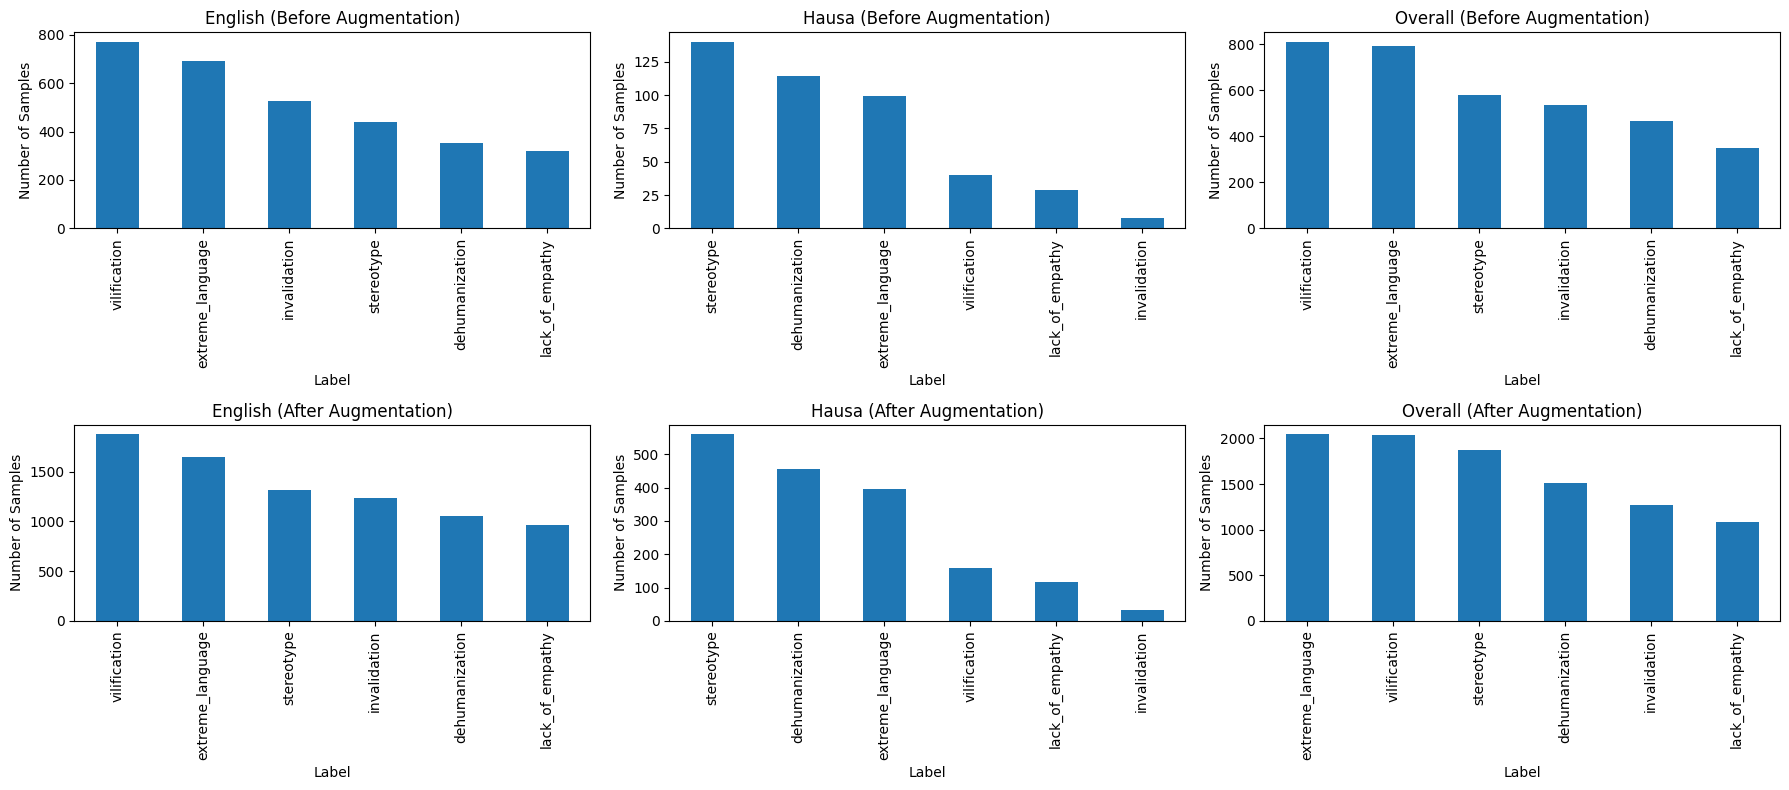

In [53]:
# Label columns
labels = ['stereotype', 'vilification', 'dehumanization',
          'extreme_language', 'lack_of_empathy', 'invalidation']

# BEFORE augmentation
dist_eng_before = train_eng_org_t3[labels].sum().sort_values(ascending=False)
dist_hau_before = train_hau_org_t3[labels].sum().sort_values(ascending=False)

train_t3_before = pd.concat([train_eng_org_t3, train_hau_org_t3], ignore_index=True)
dist_overall_before = train_t3_before[labels].sum().sort_values(ascending=False)

# AFTER augmentation
dist_eng_after = train_eng_t3[labels].sum().sort_values(ascending=False)
dist_hau_after = train_hau_t3[labels].sum().sort_values(ascending=False)
dist_overall_after = train_t3[labels].sum().sort_values(ascending=False)

#  Plot
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Row 1 — BEFORE
dist_eng_before.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title("English (Before Augmentation)")
axes[0, 0].set_ylabel("Number of Samples")
axes[0, 0].set_xlabel("Label")

dist_hau_before.plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title("Hausa (Before Augmentation)")
axes[0, 1].set_ylabel("Number of Samples")
axes[0, 1].set_xlabel("Label")

dist_overall_before.plot(kind='bar', ax=axes[0, 2])
axes[0, 2].set_title("Overall (Before Augmentation)")
axes[0, 2].set_ylabel("Number of Samples")
axes[0, 2].set_xlabel("Label")

# Row 2 — AFTER
dist_eng_after.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title("English (After Augmentation)")
axes[1, 0].set_ylabel("Number of Samples")
axes[1, 0].set_xlabel("Label")

dist_hau_after.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title("Hausa (After Augmentation)")
axes[1, 1].set_ylabel("Number of Samples")
axes[1, 1].set_xlabel("Label")

dist_overall_after.plot(kind='bar', ax=axes[1, 2])
axes[1, 2].set_title("Overall (After Augmentation)")
axes[1, 2].set_ylabel("Number of Samples")
axes[1, 2].set_xlabel("Label")

plt.tight_layout()
naming='TF IDF Aug T3 data bars'
plt.savefig(f'drive/MyDrive/NLP/{naming}.pdf',format='pdf',dpi=300)
plt.show()


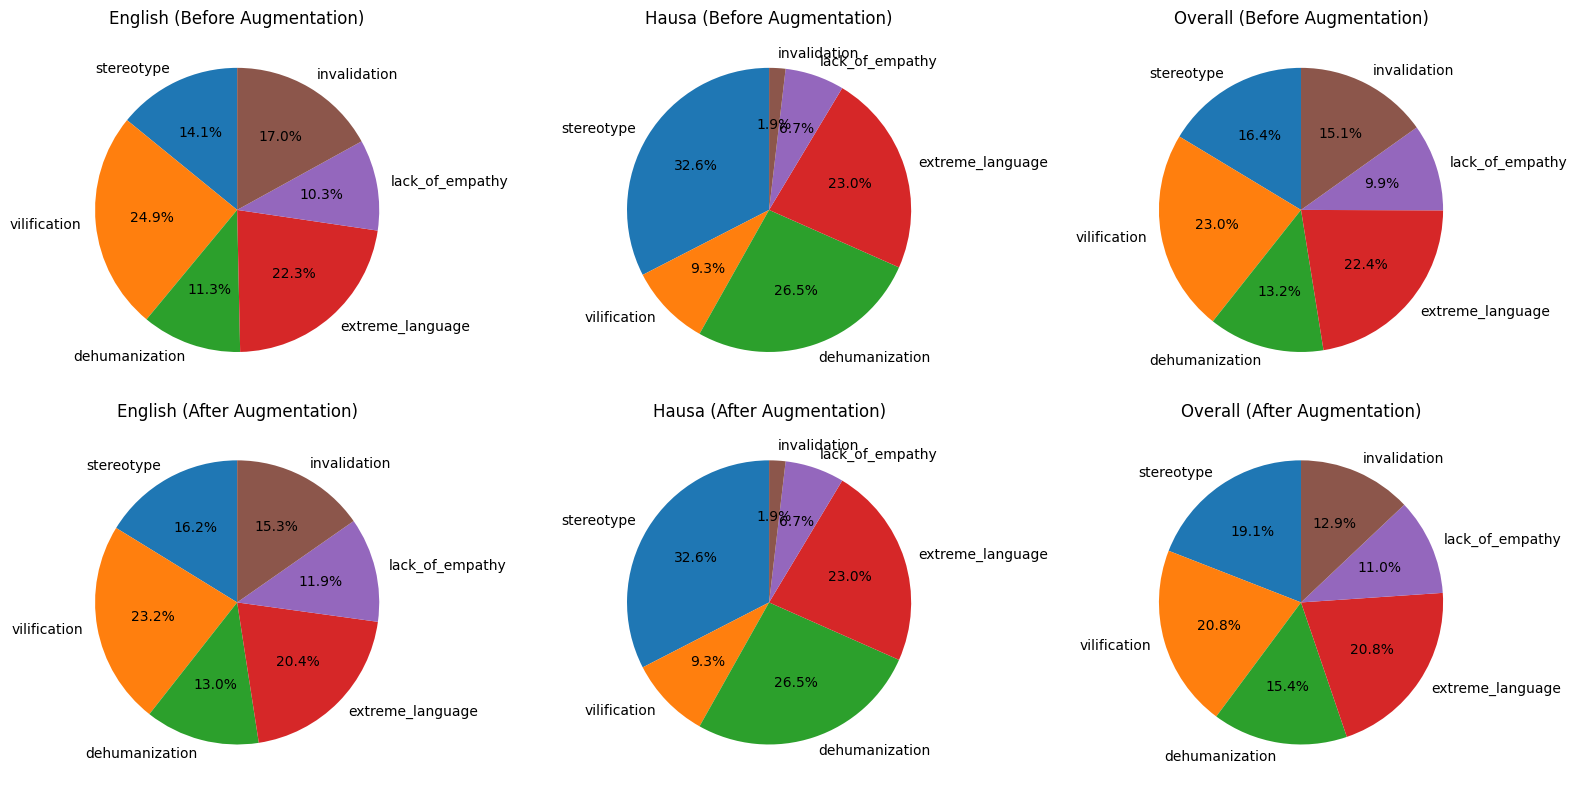

Desired Label Distribution (Uniform): 16.67%


In [54]:
# Label columns
labels = ['stereotype', 'vilification', 'dehumanization',
          'extreme_language', 'lack_of_empathy', 'invalidation']

#  BEFORE augmentation
dist_eng_before = train_eng_org_t3[labels].sum()
dist_hau_before = train_hau_org_t3[labels].sum()

train_t3_before = pd.concat([train_eng_org_t3, train_hau_org_t3], ignore_index=True)
dist_overall_before = train_t3_before[labels].sum()

# AFTER augmentation
dist_eng_after = train_eng_t3[labels].sum()
dist_hau_after = train_hau_t3[labels].sum()
dist_overall_after = train_t3[labels].sum()


fig, axes = plt.subplots(2, 3, figsize=(16, 8))

# Row 1 — BEFORE
axes[0, 0].pie(dist_eng_before, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title("English (Before Augmentation)")

axes[0, 1].pie(dist_hau_before, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title("Hausa (Before Augmentation)")

axes[0, 2].pie(dist_overall_before, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0, 2].set_title("Overall (Before Augmentation)")

# Row 2 — AFTER
axes[1, 0].pie(dist_eng_after, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title("English (After Augmentation)")

axes[1, 1].pie(dist_hau_after, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title("Hausa (After Augmentation)")

axes[1, 2].pie(dist_overall_after, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title("Overall (After Augmentation)")

plt.tight_layout()
naming='TF IDF Aug T3 data pie'
plt.savefig(f'drive/MyDrive/NLP/{naming}.pdf',format='pdf',dpi=300)
plt.show()

print(f"Desired Label Distribution (Uniform): {100/len(labels):.2f}%")


### **3.2 TF-IDF Vectorizer & DataSet**

In [55]:
tfidf=TfidfVectorizer(
    ngram_range=(1,2),
    max_features=10000,
    sublinear_tf=True
)

# TF-IDF
X_train_t3 = tfidf.fit_transform(train_t3['text'])
X_val_t3 = tfidf.transform(val_t3['text'])

# Labels
labels_t3 = ['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']
y_train_t3 = train_t3[labels_t3]
y_val_t3 = val_t3[labels_t3]

### **3.3 Model Training**

#### **3.3.1 Model Training**

In [56]:
# Train Logistic Regression with OneVsRest
clf_t3, metrics_t3 = train_evaluate_logreg(X_train_t3, y_train_t3, X_val_t3, y_val_t3, multi_label=True)
print("Subtask 3 metrics:", metrics_t3)

Subtask 3 metrics: {'f1_macro': 0.17469956510658866, 'f1_micro': 0.20662768031189083}


#### **3.3.2 Test on dev set**

In [57]:

X_dev_eng_t3 = tfidf.transform(dev_set_eng_t3['text'])
X_dev_hau_t3 = tfidf.transform(dev_set_hau_t3['text'])


y_dev_eng_t3 = clf_t3.predict(X_dev_eng_t3)
y_dev_hau_t3 = clf_t3.predict(X_dev_hau_t3)

labels_t3 = ['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']

pred_data_t3 = {
    "eng": {'ids': dev_set_eng_t3['id'].tolist(), 'results': y_dev_eng_t3},
    "hau": {'ids': dev_set_hau_t3['id'].tolist(), 'results': y_dev_hau_t3}
}

#### **3.3.3 Making Submission Package**

In [58]:
submission_dict = {}
for lang in pred_data_t3:
    df = pd.DataFrame({"id": pred_data_t3[lang]['ids'], **{lbl: pred_data_t3[lang]['results'][:,i] for i,lbl in enumerate(labels_t3)}})
    submission_dict[lang] = df

create_submission_zip('subtask_3',submission_dict)

Submission zip created at: ./subtask_3.zip


#### **3.3.4 Saving the Model**

In [59]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
naming='TF_IDF Aug'
save_path = f"saved_model_t3_{naming}_f1_{metrics_t2['f1_macro']:.4f}_{timestamp}"
save_model(clf_t1, 'drive/MyDrive/NLP/models'+'//'+save_path)

Model saved at: drive/MyDrive/NLP/models//saved_model_t3_TF_IDF Aug_f1_0.1831_20251215_181532


### **3.5 Plot of Important Words**

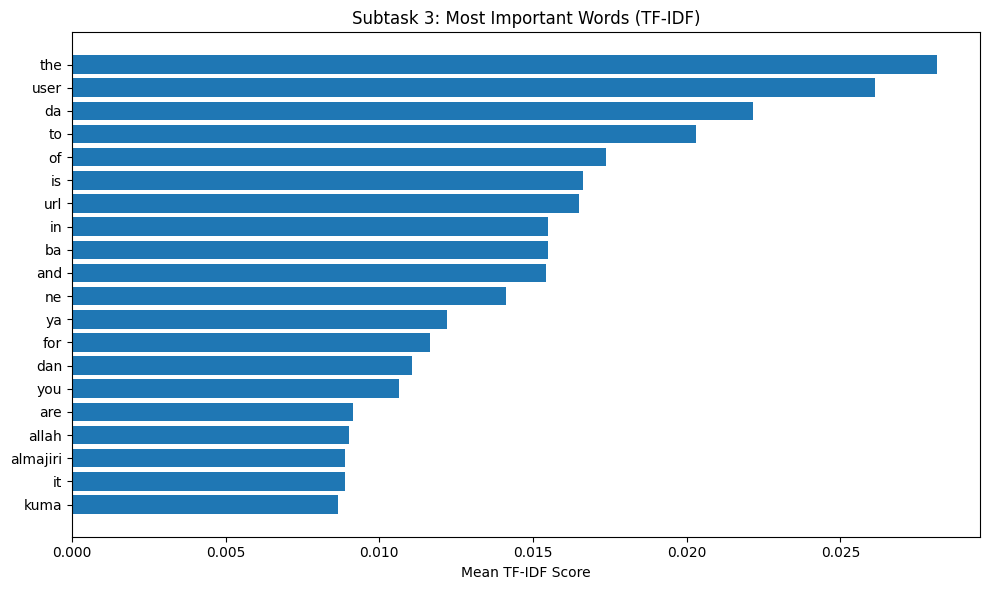

In [60]:
plot_top_tfidf_words(
    tfidf,
    X_train_t3,
    top_k=20,
    title="Subtask 3: Most Important Words (TF-IDF)",
    naming='TF IDF_T1_words'
)

### **3.6 Confusion Matrix**

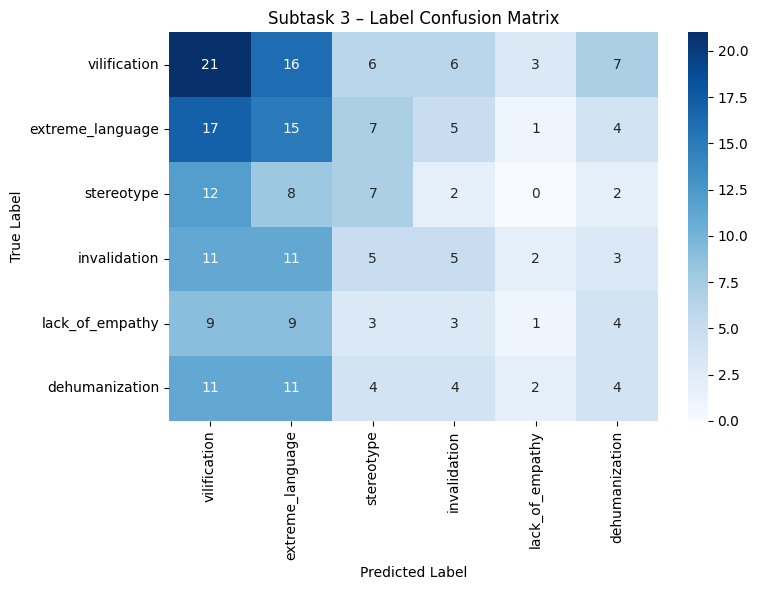

In [61]:
y_val_pred_t3 = clf_t3.predict(X_val_t3)

plot_label_confusion_matrix(
    y_val_t3,
    y_val_pred_t3,
    labels_t3,
    title="Subtask 3 – Label Confusion Matrix",
    naming='TF IDF_T3'
)